In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from EnvLibs.DRL_EnvSim import DRLResourceSchedulingEnv
import os
from datetime import datetime
from EnvLibs import Environment, RewardKernel, TrafficGenerator

def PolicyDemoFixed(u, params):
    alpha = 0.2
    w = typeAllocator(u, params['LEN_window'])
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    M = 3
    return w, r, M, alpha

def PolicyDemoAdaptiveAlpha(u, params): 
    rewardKernel = RewardKernel(params)
    w = typeAllocator(u, params['LEN_window'])
    M = 3 
    alphaList = np.linspace(0.01, 1.0, 100)
    JmdpRecord = []
    for alpha in alphaList:
        r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w 
        Jmdp = rewardKernel.getReward(u, w, r, M, alpha)
        JmdpRecord.append(Jmdp)
    alpha = alphaList[np.argmin(JmdpRecord)]
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    return w, r, M, alpha

def typeAllocator(u, lEN_window):
    w = (u>int(lEN_window*0.5)).astype(int)
    return w
    

In [2]:
def runSimulation(policy, params, trafficGenerator, num_epochs=1000):
    """
    Run simulation with a given policy function
    
    Args:
        policy_func: Function that takes (u, params) and returns (w, r, M, alpha) as action
        params: Dictionary of parameters
        num_epochs: Number of simulation epochs (default: 1000)
    
    Returns:
        rewardRecord: List of rewards for each epoch
    """
    env = Environment(params, trafficGenerator)
    rewardRecord = []
    alphaRecord = []
    for epoch in range(num_epochs):
        #u = env.updateStates()
        u = env.trafficGenerator.updateReadTraffic()
        (w, r, M, alpha) = policy(u, params)
        reward = env.applyActions(np.array(w), np.array(r), M, alpha)
        rewardRecord.append(reward)
        alphaRecord.append(alpha)
    
    return rewardRecord, alphaRecord, env

In [3]:
def test_single_episode(
    model_path=None,
    max_steps=5000,
    save_plot=True,
    plot_dir="plots"
):
    """
    Test a single episode and plot step-by-step rewards for DRL, Adaptive, and MDP policies
    
    Args:
        model_path: Path to the saved model (if None, auto-generates based on config)
        max_steps: Maximum steps in the episode
        save_plot: Whether to save the plot
        plot_dir: Directory to save plot
    """
    
    # Use exact same parameters as demo01/demo02
    params = {
        'N_user': 4,
        'LEN_window': 10,
        'r_bar': 4,
        'B': 30,
        'randomSeed': 42,
    }
    
    print(f"\n{'='*60}")
    print(f"ENVIRONMENT CONFIGURATION")
    print(f"{'='*60}")
    print(f"Number of Users (N_user): {params['N_user']}")
    print(f"Window Length (LEN_window): {params['LEN_window']}")
    print(f"Minimum Rate (r_bar): {params['r_bar']}")
    print(f"Total Bandwidth (B): {params['B']}")
    print(f"Random Seed: {params['randomSeed']}")
    print(f"Max Steps: {max_steps}")
    
    # Auto-generate model path if not provided
    if model_path is None:
        model_path = f"models/sac_mdp_scheduling_N_u={params['N_user']},B={params['B']}.zip"
    
    print(f"Looking for model: {model_path}")
    
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Error: Model file {model_path} not found!")
        return
    
    # Load traffic data and MDP kernel
    import pickle
    with open('Results/TrafficData/trafficData.pkl', 'rb') as f:
        trafficData = pickle.load(f)
    
    with open('Results/mdpKernel.pkl', 'rb') as f:
        mdpKernel = pickle.load(f)
    
    from EnvLibs import TrafficGenerator
    
    print(f"\n{'='*60}")
    print(f"RUNNING SIMULATIONS")
    print(f"{'='*60}")
    
    # Run Adaptive Policy simulation
    print("Running Adaptive Policy simulation...")
    trafficGenerator = TrafficGenerator(params)
    trafficGenerator.registerDataset(trafficData['traffic'])
    adaptive_rewards, _, _ = runSimulation(PolicyDemoAdaptiveAlpha, params, trafficGenerator, num_epochs=max_steps)
    
    # Reset traffic generator for MDP
    print("Running MDP Policy simulation...")
    trafficGenerator = TrafficGenerator(params)
    trafficGenerator.registerDataset(trafficData['traffic'])
    
    # Create wrapper function for MdpKernel to match the expected signature
    def mdp_policy_wrapper(u, params):
        return mdpKernel.getActionFromObervation(u)
    
    mdp_rewards, _, _ = runSimulation(mdp_policy_wrapper, params, trafficGenerator, num_epochs=max_steps)
    
    # Load and test DRL model
    print("Running DRL Agent simulation...")
    model = SAC.load(model_path)
    
    # Create DRL environment using the same params dictionary
    drl_env = DRLResourceSchedulingEnv(
        n_users=params['N_user'],
        len_window=params['LEN_window'],
        r_bar=params['r_bar'],
        bandwidth=params['B'],
        max_episode_steps=max_steps,
        action_mode="full_action",
        traffic_update_mode="sequential",
        use_real_traffic=True,
        random_seed=params['randomSeed']
    )

    obs, _ = drl_env.reset()
    drl_rewards = []
    
    for step in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = drl_env.step(action)
        drl_rewards.append(-reward)  # Convert to positive packet loss
        if done:
            break
    
    drl_env.close()
    
    # Calculate averages
    drl_avg = np.mean(drl_rewards)
    adaptive_avg = np.mean(adaptive_rewards[:len(drl_rewards)])
    mdp_avg = np.mean(mdp_rewards[:len(drl_rewards)])
    
    print(f"\n{'='*60}")
    print(f"COMPARISON RESULTS")
    print(f"{'='*60}")
    print(f"Total Steps: {len(drl_rewards)}")
    print(f"\nDRL Agent:")
    print(f"  Average Packet Loss: {drl_avg:.4f}")
    print(f"\nAdaptive Policy:")
    print(f"  Average Packet Loss: {adaptive_avg:.4f}")
    print(f"\nMDP Policy:")
    print(f"  Average Packet Loss: {mdp_avg:.4f}")

    # Performance ranking
    print(f"\nPerformance Ranking (lower is better):")
    policies = [('DRL Agent', drl_avg), ('Adaptive Policy', adaptive_avg), ('MDP Policy', mdp_avg)]
    policies.sort(key=lambda x: x[1])
    for i, (name, avg_loss) in enumerate(policies, 1):
        print(f"  {i}. {name}: {avg_loss:.4f}")

    # Create the COMPARISON plot (all three algorithms)
    plt.figure(figsize=(14, 8))
    steps = range(1, len(drl_rewards) + 1)
    
    # Plot all three algorithms
    plt.plot(steps, drl_rewards, 'blue', linewidth=1, alpha=0.8, label='DRL Agent (SAC)')
    plt.plot(steps, adaptive_rewards[:len(drl_rewards)], 'orange', linewidth=1, alpha=0.8, label='Adaptive Policy')
    plt.plot(steps, mdp_rewards[:len(drl_rewards)], 'green', linewidth=1, alpha=0.8, label='MDP Policy')
    
    # Add average lines
    plt.axhline(y=drl_avg, color='blue', linestyle='--', linewidth=2, alpha=0.7,
                label=f'DRL Avg: {drl_avg:.4f}')
    plt.axhline(y=adaptive_avg, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Adaptive Avg: {adaptive_avg:.4f}')
    plt.axhline(y=mdp_avg, color='green', linestyle='--', linewidth=2, alpha=0.7,
                label=f'MDP Avg: {mdp_avg:.4f}')

    plt.title(f'Packet Loss Comparison: DRL vs Adaptive vs MDP ({params["N_user"]} Users, {params["B"]} BW)\n', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Step Number', fontsize=12)
    plt.ylabel('Packet Loss Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot:
        os.makedirs(plot_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_filename = f"drl_vs_adaptive_vs_mdp_comparison_{timestamp}.png"
        plot_path = os.path.join(plot_dir, plot_filename)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to: {plot_path}")
    
    plt.show()
    
    return {
        'drl_rewards': drl_rewards,
        'adaptive_rewards': adaptive_rewards[:len(drl_rewards)],
        'mdp_rewards': mdp_rewards[:len(drl_rewards)],
        'drl_avg': drl_avg,
        'adaptive_avg': adaptive_avg,
        'mdp_avg': mdp_avg,
        'num_steps': len(drl_rewards)
    }

Testing Single Episode

ENVIRONMENT CONFIGURATION
Number of Users (N_user): 4
Window Length (LEN_window): 10
Minimum Rate (r_bar): 4
Total Bandwidth (B): 30
Random Seed: 42
Max Steps: 5000
Looking for model: models/sac_mdp_scheduling_N_u=4,B=30.zip

RUNNING SIMULATIONS
Running Adaptive Policy simulation...
Running MDP Policy simulation...
Running DRL Agent simulation...
 Loaded real traffic data from: Results/TrafficData/trafficData.pkl
   Traffic data shape: (104066,)

COMPARISON RESULTS
Total Steps: 5000

DRL Agent:
  Average Packet Loss: 0.0174

Adaptive Policy:
  Average Packet Loss: 0.0475

MDP Policy:
  Average Packet Loss: 0.0199

Performance Ranking (lower is better):
  1. DRL Agent: 0.0174
  2. MDP Policy: 0.0199
  3. Adaptive Policy: 0.0475
Comparison plot saved to: plots\drl_vs_adaptive_vs_mdp_comparison_20250627_102146.png


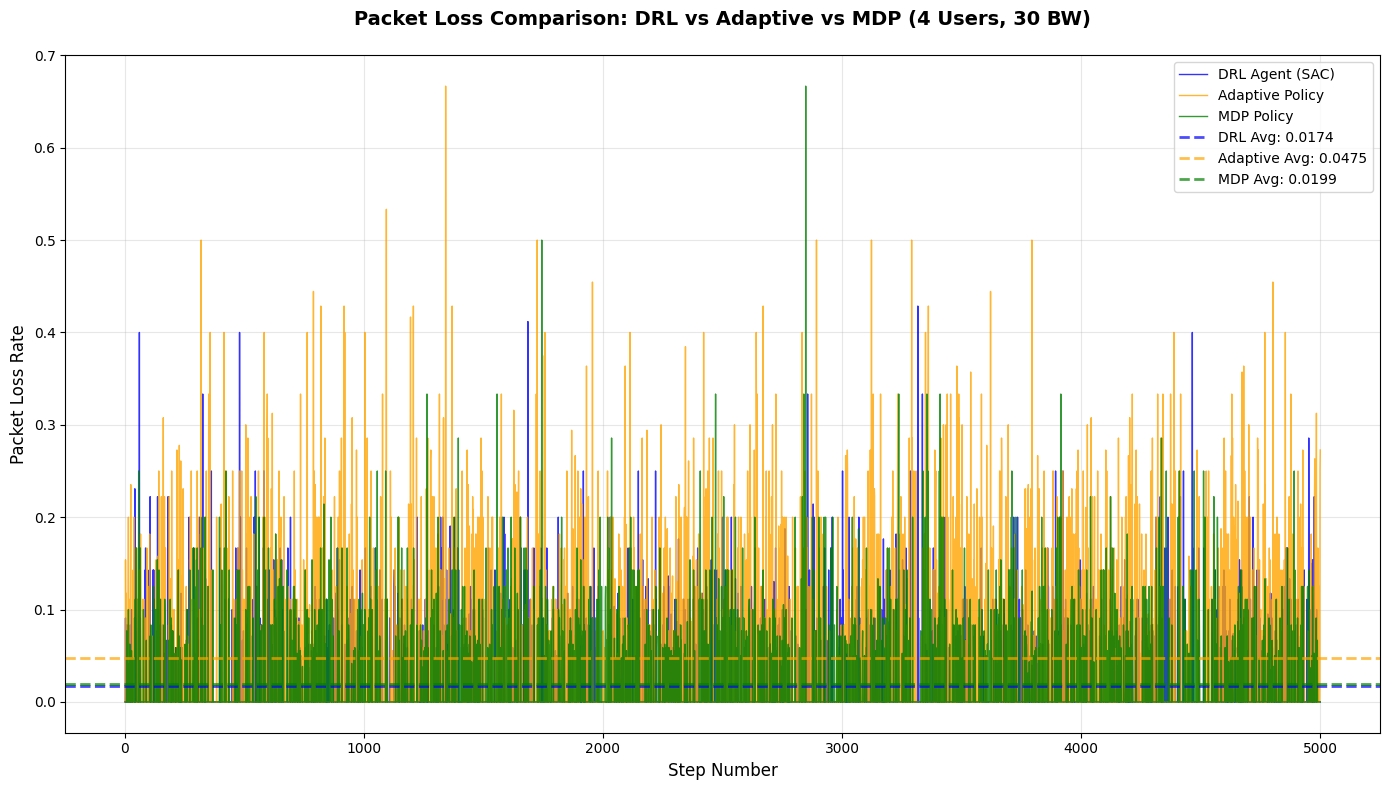

In [4]:
if __name__ == "__main__":
    print("Testing Single Episode")
    print("="*40)
    
    # Run single episode test - model path will be auto-generated
    results = test_single_episode(
        model_path=None,  # Will auto-generate: models/sac_mdp_scheduling_N_u=8,B=100.zip
        max_steps=5000,
        save_plot=True,
        plot_dir="plots"
    )